In [6]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

FEATURES = [
    "avg_kw", "peak_kw", "base_kw", "load_factor",
    "variability_cv", "peak_hour_mode",
    "peak_to_offpeak_ratio", "weekend_weekday_ratio",
    "hvac_share", "standby_share", "shiftable_share"
]

In [7]:
def build_building_features(meter_csv="data/meter_readings.csv"):
    m = pd.read_csv(meter_csv, parse_dates=["timestamp"])
    m["kwh"] = m["power_kw"] * 0.25

    bt = m.groupby(["building_id", "timestamp"], as_index=False)["power_kw"].sum()
    bt["hour"] = bt["timestamp"].dt.hour
    bt["dow"] = bt["timestamp"].dt.dayofweek
    bt["is_weekend"] = (bt["dow"] >= 5).astype(int)

    agg = bt.groupby("building_id")["power_kw"].agg(["mean", "max", "std"]).rename(
        columns={"mean": "avg_kw", "max": "peak_kw", "std": "std_kw"}
    )
    base = bt.groupby("building_id")["power_kw"].quantile(0.05).rename("base_kw")
    feat = agg.join(base)

    feat["load_factor"] = feat["avg_kw"] / feat["peak_kw"]
    feat["variability_cv"] = feat["std_kw"] / (feat["avg_kw"] + 1e-9)

    bt["is_peak_interval"] = bt.groupby("building_id")["power_kw"].transform(lambda s: s == s.max())
    peak_hours = bt[bt["is_peak_interval"]].groupby("building_id")["hour"].agg(
        lambda s: int(s.mode().iloc[0]) if len(s.mode()) else int(s.iloc[0])
    ).rename("peak_hour_mode")
    feat = feat.join(peak_hours)

    peak_mask = bt["hour"].between(18, 22)
    off_mask = bt["hour"].between(0, 6)
    peak_avg = bt[peak_mask].groupby("building_id")["power_kw"].mean().rename("peak_avg_kw")
    off_avg = bt[off_mask].groupby("building_id")["power_kw"].mean().rename("off_avg_kw")
    feat = feat.join(peak_avg).join(off_avg)
    feat["peak_to_offpeak_ratio"] = feat["peak_avg_kw"] / (feat["off_avg_kw"] + 1e-9)
    feat.drop(columns=["peak_avg_kw", "off_avg_kw"], inplace=True)

    wknd = bt[bt["is_weekend"] == 1].groupby("building_id")["power_kw"].mean().rename("wknd_kw")
    wkdy = bt[bt["is_weekend"] == 0].groupby("building_id")["power_kw"].mean().rename("wkdy_kw")
    feat = feat.join(wknd).join(wkdy)
    feat["weekend_weekday_ratio"] = feat["wknd_kw"] / (feat["wkdy_kw"] + 1e-9)
    feat.drop(columns=["wknd_kw", "wkdy_kw"], inplace=True)

    app = m.groupby(["building_id", "appliance"], as_index=False)["kwh"].sum()
    total = app.groupby("building_id")["kwh"].sum().rename("total_kwh")
    app = app.merge(total, on="building_id", how="left")
    app["share"] = app["kwh"] / (app["total_kwh"] + 1e-9)

    hvac_share = app[app["appliance"] == "HVAC"].set_index("building_id")["share"].rename("hvac_share")
    standby_like = app[app["appliance"].isin(["Fridge", "TV", "Computers"])].groupby("building_id")["share"].sum().rename("standby_share")
    shiftable = app[app["appliance"].isin(["Washer", "Dryer", "Dishwasher", "Oven", "EVCharger", "WaterHeater", "Lighting"])].groupby("building_id")["share"].sum().rename("shiftable_share")

    feat = feat.join(hvac_share).join(standby_like).join(shiftable)
    feat[["hvac_share", "standby_share", "shiftable_share"]] = feat[["hvac_share", "standby_share", "shiftable_share"]].fillna(0.0)

    return feat.reset_index()

In [ ]:
def sweep_kmeans(X, k_min=2, k_max=10, random_state=42):
    rows = []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        rows.append({"k": k, "inertia": float(km.inertia_), "silhouette": float(sil)})
    return pd.DataFrame(rows).sort_values("k")

In [ ]:
os.makedirs("artifacts", exist_ok=True)

feat = build_building_features()
X = feat[FEATURES].copy()
feat.head()

,building_id,avg_kw,peak_kw,std_kw,base_kw,load_factor,variability_cv,peak_hour_mode,peak_to_offpeak_ratio,weekend_weekday_ratio,hvac_share,standby_share,shiftable_share
0,B000,4.076499,11.814863,1.948261,2.228717,0.345031,0.477925,13,1.333393,1.002727,0.388569,0.372442,0.238988
1,B001,2.854151,11.223588,1.477095,1.556827,0.254299,0.517525,21,1.368744,0.798550,0.368757,0.389045,0.242198
2,B002,8.432095,24.017433,3.701019,4.336919,0.351082,0.438920,19,2.432962,0.759008,0.420384,0.307699,0.271916
3,B003,4.481759,13.332927,2.012933,2.126388,0.336142,0.449139,18,2.707064,1.001554,0.481758,0.256243,0.261999
4,B004,5.241168,14.707867,2.428552,2.895294,0.356351,0.463361,13,1.294809,0.994852,0.377333,0.390171,0.232496


<Axes: >

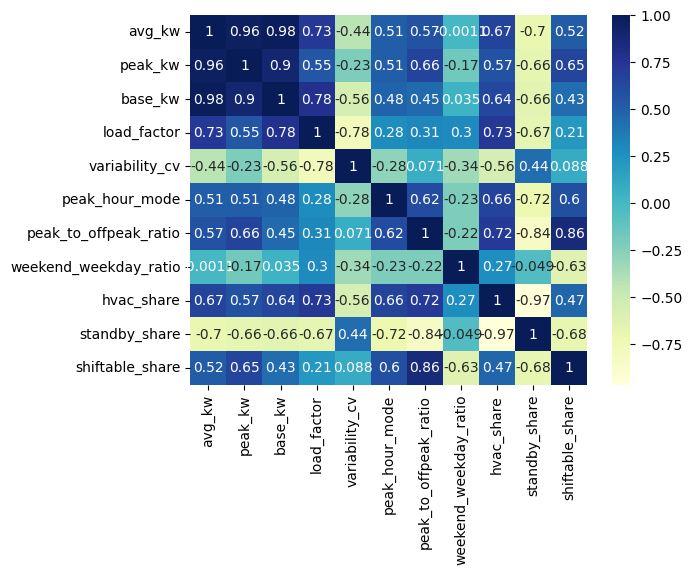

In [16]:
import seaborn as sns
correlation= X.corr(numeric_only=True)
sns.heatmap(correlation, cmap="YlGnBu", annot=True)

In [ ]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=0.90, random_state=42)
Xp = pca.fit_transform(Xs)

evr = pca.explained_variance_ratio_
pca_ev = pd.DataFrame({
    "component": np.arange(1, len(evr) + 1),
    "explained_variance_ratio": evr,
    "cumulative_explained_variance": np.cumsum(evr)
})
pca_ev.to_csv("artifacts/pca_explained_variance.csv", index=False)

loadings = pd.DataFrame(
    pca.components_,
    columns=FEATURES,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings.to_csv("artifacts/pca_loadings.csv")

In [ ]:
k_sweep = sweep_kmeans(Xp, 2, 10, random_state=42)
k_sweep.to_csv("artifacts/k_sweep.csv", index=False)

best_k = int(k_sweep.sort_values("silhouette", ascending=False).iloc[0]["k"])
best_k

8

In [ ]:
km = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels = km.fit_predict(Xp)

In [ ]:
pc1 = Xp[:, 0]
pc2 = Xp[:, 1] if Xp.shape[1] > 1 else np.zeros_like(pc1)

scores2d = pd.DataFrame({
    "building_id": feat["building_id"].values,
    "pc1": pc1,
    "pc2": pc2,
    "cluster": labels
})
scores2d.to_csv("artifacts/pca_scores_2d.csv", index=False)

sil_samples = silhouette_samples(Xp, labels)
sil_df = pd.DataFrame({
    "building_id": feat["building_id"].values,
    "cluster": labels,
    "silhouette": sil_samples
})
sil_df.to_csv("artifacts/silhouette_samples.csv", index=False)

In [ ]:
segmented = feat.copy()
segmented["cluster"] = labels
segmented.to_csv("artifacts/building_segments.csv", index=False)

prof = segmented.groupby("cluster")[FEATURES].mean()
prof["count"] = segmented.groupby("cluster")["building_id"].size()
prof = prof.reset_index()
prof.to_csv("artifacts/cluster_profiles.csv", index=False)

joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(pca, "artifacts/pca.joblib")
joblib.dump(km, "artifacts/kmeans.joblib")

print("Saved all artifacts successfully.")

Saved all artifacts successfully.
